In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'baba' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 5 # for predicting 1 day ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/2/21 1D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/2/21 1D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/2/21 1D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/2/21 1D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/2/21 1D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/2/21 1D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/2/21 1D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/2/21 1D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/2/21 1D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/2/21 1D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/2/21 1D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/2/21 1D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/2/21 1D, 5D ahead
               , 'msft': '03/10/1986' # Updated 1/2/21 1D, 5D ahead
               , 'nio': '09/10/2018' # Updated 1/2/21 1D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 1/2/21 1D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 1/2/21 1D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 1/2/21 1D, 5D ahead
               , 'v': '03/16/2008' # Updated 1/2/21 1D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 1/2/21 1D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 1/2/21 1D, 5D ahead
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-21,260.459991,254.500000,255.169998,260.429993,10901800,260.429993,-0.020614,0.023418,0.001654,0.016085,0.003517,1
2020-12-22,258.339996,255.410004,257.869995,255.830002,11468400,255.830002,0.007911,0.011472,-0.017663,0.018663,0.000703,1
2020-12-23,257.350006,252.529999,255.500000,256.179993,10729200,256.179993,-0.002661,0.019087,0.001368,0.012219,-0.004339,-1
2020-12-24,229.899994,211.229996,228.235001,222.000000,141830000,222.000000,0.027318,0.088387,-0.133422,0.056934,-0.032963,1
2020-12-28,224.990005,215.320007,216.880005,222.360001,73512100,222.360001,-0.025267,0.044910,0.001622,0.058804,-0.029288,1
2020-12-29,239.190002,229.600006,231.759995,236.259995,69715900,236.259995,-0.019417,0.041768,0.062511,0.071695,-0.017117,-1
2020-12-30,243.389999,234.645004,243.348007,238.389999,44812300,238.389999,0.020374,0.037269,0.009016,0.072631,-0.011781,-1
2020-12-31,238.919998,231.026993,237.460007,232.729996,23406900,232.729996,0.019919,0.034165,-0.023743,0.072362,-0.016803,-1
2021-01-04,230.380005,225.039993,226.500000,227.850006,24871200,227.850006,-0.005960,0.023729,-0.020968,0.034761,0.005687,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

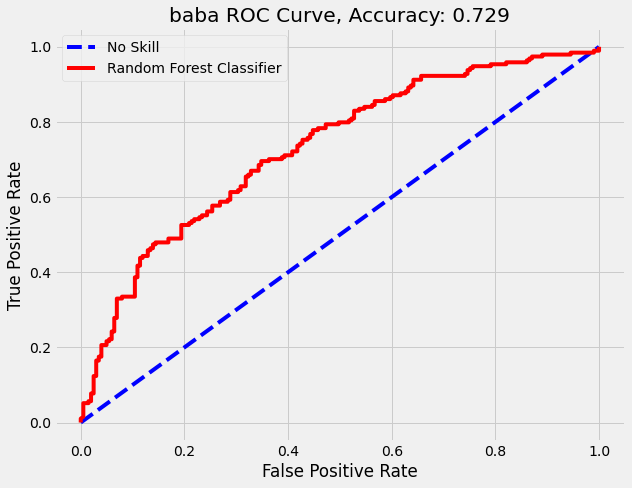

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

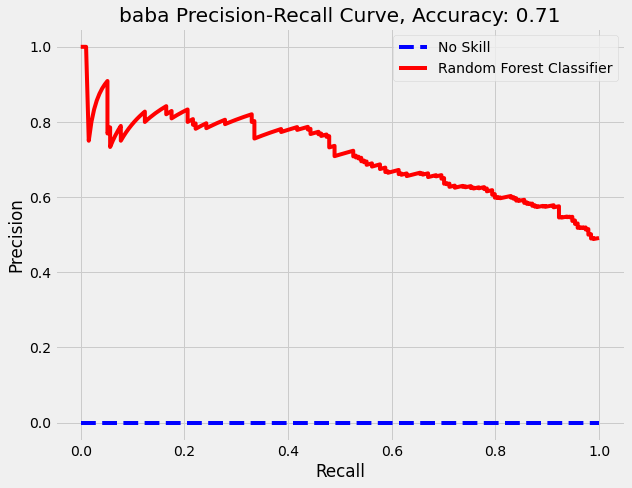

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

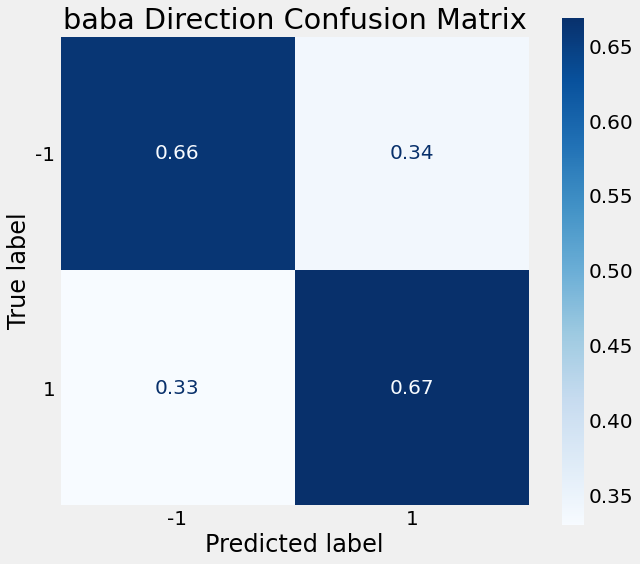

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6765822784810126'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          2.404600e+02
Low           2.281200e+02
Open          2.290500e+02
Close         2.396900e+02
Volume        2.280077e+07
Adj Close     2.396900e+02
oc           -4.645274e-02
hl            5.409439e-02
adj           5.196399e-02
5stdev_adj    4.016009e-02
5sma_adj      1.575593e-02
direction    -1.000000e+00
Name: 2021-01-05 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
last

oc            0.009708
hl            0.019087
5stdev_adj    0.029162
5sma_adj     -0.002211
Name: 2014-09-29 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    1580.000000
mean        0.000851
std         0.021130
min        -0.133422
25%        -0.010669
50%         0.000671
75%         0.012446
max         0.132919
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name} {days_ahead} day(s) ahead')
else:
    print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

Buy baba 5 day(s) ahead


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-29,239.190002,229.600006,231.759995,236.259995,69715900,236.259995,-0.019417,0.041768,0.062511,0.071695,-0.017117,-1,-1,-0.009016
2020-12-30,243.389999,234.645004,243.348007,238.389999,44812300,238.389999,0.020374,0.037269,0.009016,0.072631,-0.011781,-1,1,-0.023743
2020-12-31,238.919998,231.026993,237.460007,232.729996,23406900,232.729996,0.019919,0.034165,-0.023743,0.072362,-0.016803,-1,1,-0.020968
2021-01-04,230.380005,225.039993,226.500000,227.850006,24871200,227.850006,-0.005960,0.023729,-0.020968,0.034761,0.005687,-1,-1,-0.051964
2021-01-05,240.460007,228.119995,229.050003,239.690002,22800767,239.690002,-0.046453,0.054094,0.051964,0.040160,0.015756,-1,-1,-0.000671


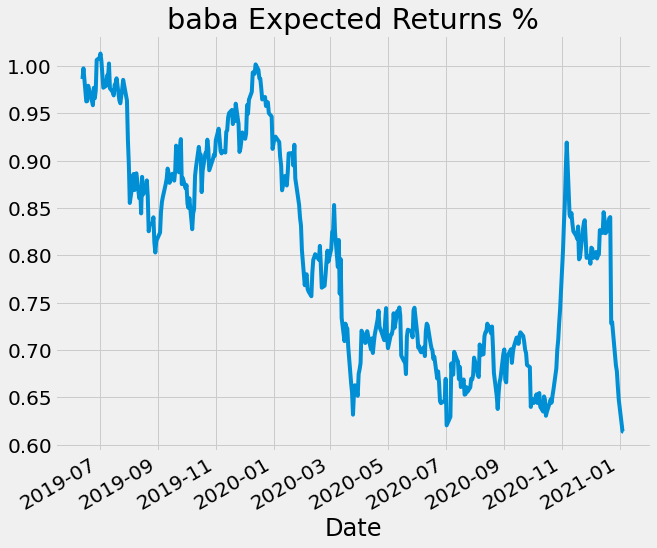

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

1.0065733175738616

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

2.000250397704516

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

In [22]:
# this takes a while, 9.5+ hours!
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

### Recording Results